In [652]:
library(dplyr)
library(tibble)
library(tidyr)

library(Biobase)
library(gPCA)
library(pvca)

library(ggplot2)
library(cowplot)
theme_set(theme_bw())

# library(scran)
# library(sva)
# library(Harman)


Attaching package: ‘dplyr’


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
options(repr.plot.width = 6, repr.plot.height = 4)

In [553]:
# source files
src_files <- list.files('../../relapse_prediction/R', full.names = TRUE)
for (f in src_files) {
  source(f)
  cat(sprintf('Sourced file: %s\n', f))
}

Sourced file: ../../relapse_prediction/R/batch.R
Sourced file: ../../relapse_prediction/R/calc.R
Sourced file: ../../relapse_prediction/R/misc.R
Sourced file: ../../relapse_prediction/R/normalise.R
Sourced file: ../../relapse_prediction/R/plot.R
Sourced file: ../../relapse_prediction/R/predict.R
Sourced file: ../../relapse_prediction/R/subset.R
Sourced file: ../../relapse_prediction/R/utils.R


# Import data

In [4]:
file_maqc <- "../data/MAQC-I/processed/mas5_original-ref.tsv"
raw_maqc <- read.table(file_maqc, sep = "\t", header = T, row.names = 1)

# MAQC metadata
# Class A - Universal Human Reference RNA (UHRR)
# Class B - Human Brain Reference RNA (HBRR)
batch_info <- as.factor(rep(1:6, each = 10))
class_info <- rep(rep(LETTERS[1:2], each = 5), 6)
metadata <- data.frame(
  batch_info, class_info,
  row.names = colnames(raw_maqc)
)

# SCALE->REMOVE->FILTER->LOG
scaled_maqc <- raw_maqc %>%
  normaliseMeanScaling()

log_maqc <- scaled_maqc %>%
  removeProbesets() %>%
  filterProbesets(0.7, metadata) %>%
  log2_transform()

AFX_1_A1 AFX_1_A2 AFX_1_A3 AFX_1_A4 AFX_1_A5 AFX_1_B1 
6.167267 4.921776 6.064782 5.998307 5.594024 6.396092 
[1] "No. of ambiguous and AFFY probesets removed: 17320"
[1] "No. of probesets removed = 18820"


In [33]:
# log_nozero <- log_maqc[rowSums(log_maqc == 0) == 0, ]

# Measuring batch effects
- Different batch-class imbalance
- No batch effects
- Different magnitude of batch effects when there is batch-class imbalance
- Measure when there is different number of features
- Different batch sizes

### Comparisons
- gPCA delta: 0-1 (proportion of variance)
    - Weak in quantifying small amounts of batch effects?
    - Problems when there is no batch effects but there is class imbalance

In [5]:
# var_pct
quantify_batch <- function(X, metadata) {
  batch <- metadata[colnames(X), 'batch_info']
  class <- metadata[colnames(X), "class_info"]
  print(batch)
  print(class)

  batchpct_v1 <- calc_var_pct(X, batch)
  batchpct <- calc_var_pct(X, batch, class, ret.obj = T)
  rounded_pcts <- sapply(batchpct$pi_classes, round, digits = 4)
  pct_classes <- do.call(paste, as.list(c(rounded_pcts, sep = '; ')))
  batch_dists <- calc_batch_dist(X, metadata)
  gpca <- gPCA.batchdetect(t(X), batch)
  
  list(
    pct_v1 = batchpct_v1,
    pct_v2 = pct_classes,
    pct_v3 = batchpct$pi_total,
    batch_dist = sum(batch_dists),
    gpca_delta = gpca$delta,
    gpca_pvalue = gpca$p.val
  )
}

In [150]:
# subsetting maqc
maqc_bal <- log_maqc[, c(1:4, 6:9, 11:14, 16:19)]
maqc_imbal <- log_maqc[, c(1:3, 6:10, 11:15, 16:18)]
maqc_fakebatch <- log_maqc[, c(1:4, 6:9)]

In [152]:
fake_metadata <- metadata[colnames(maqc_fakebatch), ]

In [161]:
fake_metadata[3, 1] <- 2
fake_metadata[6, 1] <- 1

,batch_info,class_info
,<fct>,<fct>
AFX_1_A1,1,A
AFX_1_A2,1,A
AFX_1_A3,2,A
AFX_1_A4,2,A
AFX_1_B1,1,B
AFX_1_B2,1,B
AFX_1_B3,2,B
AFX_1_B4,2,B


In [156]:
quantify_batch(maqc_fakebatch, fake_metadata)

[1] 1 1 1 2 1 2 2 2
Levels: 1 2 3 4 5 6
[1] A A A A B B B B
Levels: A B
Split into classes: A B


$pct_v1
[1] 0.2158695

$pct_v2
[1] "0.3273; 0.3258"

$pct_v3
[1] 0.08639798

$batch_dist
[1] 59785.32

$gpca_delta
[1] 0.85822

$gpca_pvalue
[1] 0.206

#### PVCA

In [177]:
# create expressionset from biobase package
meta_metadata <- data.frame(labelDescription = colnames(metadata))
pheno_data <- new("AnnotatedDataFrame", data = metadata, varMetadata = meta_metadata)
maqc_eset <- ExpressionSet(assayData = as.matrix(log_maqc), phenoData = pheno_data)

In [178]:
eset <- maqc_eset[, c(1:4, 6:9, 11:14, 16:19)]

In [172]:
# create expressionset from biobase package
print(fake_metadata)
fake_pheno_data <- new("AnnotatedDataFrame", data = fake_metadata, varMetadata = meta_metadata)
fakebatch_eset <- ExpressionSet(assayData = as.matrix(maqc_fakebatch), phenoData = fake_pheno_data)

         batch_info class_info
AFX_1_A1          1          A
AFX_1_A2          1          A
AFX_1_A3          2          A
AFX_1_A4          2          A
AFX_1_B1          1          B
AFX_1_B2          1          B
AFX_1_B3          2          B
AFX_1_B4          2          B


In [191]:
pvca_obj <- pvcaBatchAssess(eset, c('batch_info', 'class_info'), 0.6)
var_prop <- as.vector(pvca_obj$dat)
factors <- as.vector(pvca_obj$label)
print(factors)
rounded_prop <- sapply(var_prop, round, digits = 4)
do.call(paste, as.list(c(rounded_prop, sep = '; ')))

singular fit
singular fit
singular fit


[1] "batch_info:class_info" "class_info"            "batch_info"           
[4] "resid"                


[1] "0.0492; 0.8484; 0.1012; 0.0012"

## Ma-Spore ALL

In [7]:
# Metadata
METADATA_SID <- "../../relapse_prediction/data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "../../relapse_prediction/data/GSE67684/processed/metadata/pid-metadata_v7.tsv"
metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')

## Data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "../../relapse_prediction/data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")

In [8]:
# Metadata
metadata_sid$label <- as.factor(metadata_sid$label)
levels(metadata_sid$label) <- c('Remission', 'Relapse')
metadata_sid$batch_info <- as.factor(metadata_sid$batch_info) 
metadata_pid$label <- as.factor(metadata_pid$label)
levels(metadata_pid$label) <- c('Remission', 'Relapse')

# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

# All features
yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] "No. of probesets removed = 6321"


In [15]:
metadata_telaml1 <- subset(
  metadata_sid,
  subtype == 'TEL-AML1' &
  label == 'Remission' &
  batch_info %in% c(2, 9)
)

In [31]:
bal_sids <- get_sid(c(
  'P022', 'P023', 'P024', 'P025',
  'P099', 'P106', 'P120', 'P121'
))
imbal_sids <- c(
  'P022_D0', 'P023_D0', 'P024_D0', 'P025_D0', 'P026_D0', 'P022_D8', 'P023_D8', 'P024_D8',
  'P099_D0', 'P106_D0', 'P120_D0', 'P099_D8', 'P106_D8', 'P120_D8', 'P121_D8', 'P127_D8'
)

In [33]:
yeoh_bal <- yeoh[, bal_sids]
yeoh_imbal <- yeoh[, imbal_sids]

In [46]:
fakebatch_sids <- get_sid(c(
  'P022', 'P023', 'P024', 'P025',
  'P026', 'P027', 'P035', 'P036'
))
yeoh_fakebatch <- yeoh[, fakebatch_sids]

In [47]:
fake_metadata <- metadata_sid[fakebatch_sids, ]
fake_metadata1 <- fake_metadata
fake_metadata2 <- fake_metadata
fake_metadata1[c(1:4, 9:12), 1] <- 1
fake_metadata2[c(1:6, 11:16), 1] <- 1

In [50]:
metrics1 <- quantify_batch(yeoh_bal, metadata_sid)

 [1] 2 2 2 2 9 9 9 9 2 2 2 2 9 9 9 9
Levels: 1 2 3 4 5 6 7 8 9 10
 [1] D0 D0 D0 D0 D0 D0 D0 D0 D8 D8 D8 D8 D8 D8 D8 D8
Levels: D0 D8 N
Split into classes: D0 D8


In [51]:
metrics2 <- quantify_batch(yeoh_imbal, metadata_sid)

 [1] 2 2 2 2 2 2 2 2 9 9 9 9 9 9 9 9
Levels: 1 2 3 4 5 6 7 8 9 10
 [1] D0 D0 D0 D0 D0 D8 D8 D8 D0 D0 D0 D8 D8 D8 D8 D8
Levels: D0 D8 N
Split into classes: D0 D8


In [53]:
metrics3 <- quantify_batch(yeoh_fakebatch, fake_metadata1)

 [1] 1 1 1 1 2 2 2 2 1 1 1 1 2 2 2 2
Levels: 1 2 3 4 5 6 7 8 9 10
 [1] D0 D0 D0 D0 D0 D0 D0 D0 D8 D8 D8 D8 D8 D8 D8 D8
Levels: D0 D8 N
Split into classes: D0 D8


In [54]:
metrics4 <- quantify_batch(yeoh_fakebatch, fake_metadata2)

 [1] 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1
Levels: 1 2 3 4 5 6 7 8 9 10
 [1] D0 D0 D0 D0 D0 D0 D0 D0 D8 D8 D8 D8 D8 D8 D8 D8
Levels: D0 D8 N
Split into classes: D0 D8


In [68]:
metrics4

$pct_v1
[1] 0.081756

$pct_v2
[1] "0.1567; 0.1732"

$pct_v3
[1] 0.1416216

$batch_dist
[1] 23122.41

$gpca_delta
[1] 0.5451259

$gpca_pvalue
[1] 0.19

# PVCA

In [58]:
metadata_yeoh <- metadata_sid[colnames(yeoh), ]

In [59]:
# create expressionset from biobase package
meta_metadata <- data.frame(labelDescription = colnames(metadata_sid))
pheno_data <- new("AnnotatedDataFrame", data = metadata_yeoh, varMetadata = meta_metadata)
yeoh_eset <- ExpressionSet(assayData = as.matrix(yeoh), phenoData = pheno_data)

In [69]:
# TODO
eset <- yeoh_eset[, imbal_sids]

In [70]:
pvca_obj <- pvcaBatchAssess(eset, c('batch_info', 'class_info'), 0.6)
var_prop <- as.vector(pvca_obj$dat)
factors <- as.vector(pvca_obj$label)
print(factors)
rounded_prop <- sapply(var_prop, round, digits = 4)
do.call(paste, as.list(c(rounded_prop, sep = '; ')))

singular fit
singular fit
singular fit
singular fit
singular fit


[1] "batch_info:class_info" "class_info"            "batch_info"           
[4] "resid"                


[1] "0.1864; 0.2284; 0.1907; 0.3944"

In [75]:
# create expressionset from biobase package
print(fake_metadata2)
fake_pheno_data <- new("AnnotatedDataFrame", data = fake_metadata2, varMetadata = meta_metadata)
fakebatch_eset <- ExpressionSet(assayData = as.matrix(yeoh_fakebatch), phenoData = fake_pheno_data)

        batch_info class_info  subtype     label
P022_D0          1         D0 TEL-AML1 Remission
P023_D0          1         D0 TEL-AML1 Remission
P024_D0          1         D0 TEL-AML1 Remission
P025_D0          1         D0 TEL-AML1 Remission
P026_D0          1         D0 TEL-AML1 Remission
P027_D0          1         D0 TEL-AML1 Remission
P035_D0          2         D0 TEL-AML1 Remission
P036_D0          2         D0 TEL-AML1 Remission
P022_D8          2         D8 TEL-AML1 Remission
P023_D8          2         D8 TEL-AML1 Remission
P024_D8          1         D8 TEL-AML1 Remission
P025_D8          1         D8 TEL-AML1 Remission
P026_D8          1         D8 TEL-AML1 Remission
P027_D8          1         D8 TEL-AML1 Remission
P035_D8          1         D8 TEL-AML1 Remission
P036_D8          1         D8 TEL-AML1 Remission


In [76]:
pvca_obj <- pvcaBatchAssess(fakebatch_eset, c('batch_info', 'class_info'), 0.6)
var_prop <- as.vector(pvca_obj$dat)
factors <- as.vector(pvca_obj$label)
print(factors)
rounded_prop <- sapply(var_prop, round, digits = 4)
do.call(paste, as.list(c(rounded_prop, sep = '; ')))

singular fit
singular fit
singular fit
singular fit
singular fit
singular fit


[1] "batch_info:class_info" "class_info"            "batch_info"           
[4] "resid"                


[1] "0.0783; 0.2255; 0.0738; 0.6225"

In [61]:
# table(metadata_sid[colnames(yeoh_imbal), c('batch_info', 'class_info')])

# Westlake

In [112]:
# # regenerate fake batch data
# file1 <- "../data/westlake-A549_K562/processed/balanced.csv"
# data <- read.table(file1, sep = ",", header = T, row.names = 1)

# file2 <- "../data/westlake-A549_K562/processed/metadata/fake_batch-balanced.csv"
# metadata <- read.table(file2, sep = ",", header = T, row.names = 1)

# fake_batch <- data[, rownames(metadata)]
# file3 <- "../data/westlake-A549_K562/processed/fake_batch.csv"
# write.csv(fake_batch, file3, quote = F)

In [120]:
file1 <- "../data/westlake-A549_K562/processed/fake_batch.csv"
file2 <- "../data/westlake-A549_K562/processed/metadata/fake_batch-severe.csv"

data <- read.table(file1, sep = ",", header = T, row.names = 1)
metadata <- read.table(file2, sep = ",", header = T, row.names = 1)
stopifnot(identical(colnames(data), rownames(metadata)))

### Time benchmarking: PCA

In [166]:
m <- 20000
n <- 1000
X <- matrix(rnorm(m * n), m, n)

start <- Sys.time()
obj <- prcomp(X)
end <- Sys.time()
print(end - start)

## Metrics

In [157]:
start <- Sys.time()
pvb <- PVB(data, metadata$machine, metadata$class)
end <- Sys.time()
print(pvb)
print(end - start)

Split into classes: A549 K562
[1] 0.03313766
Time difference of 0.430649 secs


In [147]:
start <- Sys.time()
gpca <- gPCA.batchdetect(t(data), metadata$machine, nperm = 5)
end <- Sys.time()
print(gpca$delta)
print(end - start)

[1] 0.9424993
Time difference of 0.2675877 secs


In [123]:
# create expressionset from biobase package
meta_metadata <- data.frame(labelDescription = colnames(metadata))
pheno_data <- new("AnnotatedDataFrame", data = metadata, varMetadata = meta_metadata)
eset <- ExpressionSet(assayData = as.matrix(data), phenoData = pheno_data)

In [132]:
# selected number of PCs have to account for >= 0.6 variance
start <- Sys.time()
pvca_obj <- pvcaBatchAssess(eset, c('machine', 'class'), 0.6)
end <- Sys.time()
var_prop <- as.vector(pvca_obj$dat)
factors <- as.vector(pvca_obj$label)
print(factors)
rounded_prop <- sapply(var_prop, round, digits = 4)
do.call(paste, as.list(c(rounded_prop, sep = '; ')))
print(end - start)

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



[1] "machine:class" "class"         "machine"       "resid"        


[1] "0.009; 0.9263; 0; 0.0646"

Time difference of 1.857537 secs


# BatchQC
- RNA-seq
$$
X_{ijkg} \sim \text{NB}(r = \beta + \gamma_k, \mu = \alpha + \delta_i + \delta_k + \delta_g + \epsilon * M)
$$

$$
M \sim \text{Beta}(2, 2)
$$

In [402]:
files <- list.files(dir, full.names = T)
list_data <- lapply(files, read.table, sep = "\t", header = T, row.names = 1)
id <- sapply(
  files,
  function(x) substring_head(strsplit(x, '_')[[1]][2], 4),
  USE.NAMES = FALSE
)
names(list_data) <- id

In [403]:
# metadata
ncond <- 20
batch <- as.factor(rep(1:2, each = ncond * 2))
class <- rep(rep(LETTERS[1:2], each = ncond), 2)
metadata <- data.frame(batch, class, row.names = colnames(counts))

In [439]:
batch_delta <- '9000'
X <- list_data[[batch_delta]]

In [440]:
file <- sprintf('~/Dropbox/tmp/feature-%s.pdf', batch_delta)
pdf(file, width = 4, height = 4)
plot(unlist(X[1,]), col = batch, pch = class)
dev.off()

png 
  2

In [230]:
quantify_batch <- function(X, metadata) {
  batch <- metadata[colnames(X), 'batch']
  class <- metadata[colnames(X), 'class']
  print(batch)
  print(class)

  pvb <- PVB(X, batch, class)
  batch_dists <- calc_batch_dist(X, metadata, batch_name = 'batch', class_name = 'class')
  gpca <- gPCA.batchdetect(t(X), batch)
  
  # create expressionset from biobase package
  meta_metadata <- data.frame(labelDescription = colnames(metadata))
  pheno_data <- new("AnnotatedDataFrame", data = metadata, varMetadata = meta_metadata)
  eset <- ExpressionSet(assayData = as.matrix(X), phenoData = pheno_data)
  pvca_obj <- pvcaBatchAssess(eset, c('batch', 'class'), 0.6)
  var_prop <- as.vector(pvca_obj$dat)
  labels <- as.vector(pvca_obj$label)
  names(var_prop) <- labels

  c(
    gpca.delta = gpca$delta,
    gpca.pvalue = gpca$p.val,
    pvb = pvb,
    batch_dist = sum(batch_dists),
    pvca = var_prop['batch']
  )
}

In [232]:
metrics <- lapply(list_data, quantify_batch, metadata)

 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[77] 2 2 2 2
Levels: 1 2
 [1] A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B
[39] B B A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B
[77] B B B B
Levels: A B
Split into classes: A B


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[77] 2 2 2 2
Levels: 1 2
 [1] A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B
[39] B B A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B
[77] B B B B
Levels: A B
Split into classes: A B


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[77] 2 2 2 2
Levels: 1 2
 [1] A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B
[39] B B A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B
[77] B B B B
Levels: A B
Split into classes: A B


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[77] 2 2 2 2
Levels: 1 2
 [1] A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B
[39] B B A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B
[77] B B B B
Levels: A B
Split into classes: A B


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[77] 2 2 2 2
Levels: 1 2
 [1] A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B
[39] B B A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B
[77] B B B B
Levels: A B
Split into classes: A B


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[77] 2 2 2 2
Levels: 1 2
 [1] A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B
[39] B B A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B
[77] B B B B
Levels: A B
Split into classes: A B


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[77] 2 2 2 2
Levels: 1 2
 [1] A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B
[39] B B A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B
[77] B B B B
Levels: A B
Split into classes: A B


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[77] 2 2 2 2
Levels: 1 2
 [1] A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B
[39] B B A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B
[77] B B B B
Levels: A B
Split into classes: A B


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[77] 2 2 2 2
Levels: 1 2
 [1] A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B
[39] B B A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B
[77] B B B B
Levels: A B
Split into classes: A B


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[77] 2 2 2 2
Levels: 1 2
 [1] A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B
[39] B B A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B
[77] B B B B
Levels: A B
Split into classes: A B


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[77] 2 2 2 2
Levels: 1 2
 [1] A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B
[39] B B A A A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B
[77] B B B B
Levels: A B
Split into classes: A B


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



In [738]:
# drop batch_dist and gpca p-value
metrics3 <- data.frame(metrics)[-c(2,4), ]
M1 <- rownames_to_column(metrics3)
colnames(M1)[1] <- 'feature'
M2 <- gather(M1, key = 'batch_delta', value = 'value', -feature)
M2$value <- as.numeric(M2$value)
M2$batch_delta <- as.numeric(substring(M2$batch_delta, 2))

In [780]:
metrics_short <- metrics3 %>%
  t() %>%
  data.frame() %>%
  mutate(batch_delta = substring(rownames(.), 2))

In [321]:
# ax <- ggplot(M2) +
#   geom_line(
#     aes(x = batch_delta, y = value, group = feature, col = feature),
#     show.legend = T
#   )

In [324]:
# file <- '~/Dropbox/tmp/batch_delta-metrics1.pdf'
# ggsave(file, ax, width = 6, height = 4)

# Thoughts
- Variance is not affected by shifts in means (same across genes)

# Theoretical estimates

In [ ]:
s2 <- function(delta, n) {
  if (length(delta) != 1)
    stop('Delta is not a scalar!')
  
  corr_factor <- n / (n - 1)
  biased_est <- (delta / 2) ^ 2
  unbiased_est <- biased_est * corr_factor
  
  c(unbiased = unbiased_est, biased = biased_est)
}

## PVB * SS_T

In [862]:
var_total <- sapply(list_data, function(X) sum(apply(X, 1, var)))
metrics3a <-  data.frame(var_total) %>%
  rownames_to_column(var = 'batch_delta') %>%
  merge(metrics_short, by = 'batch_delta') %>%
  mutate_all(function(x) as.numeric(as.character(x))) %>%
  mutate(var_delta = (batch_delta / 2)^2 * n * ngenes / (n - 1)) %>%
  mutate(pct_var = var_delta / var_total)

In [926]:
ax <- ggplot(metrics3a) +
  geom_line(aes(x = pct_var, y = pvb)) + 
  geom_abline(slope = 1, intercept = 0, col = 'red') +
  ylim(0, 0.2)
#   theme(axis.text.x = element_text(angle = 0))

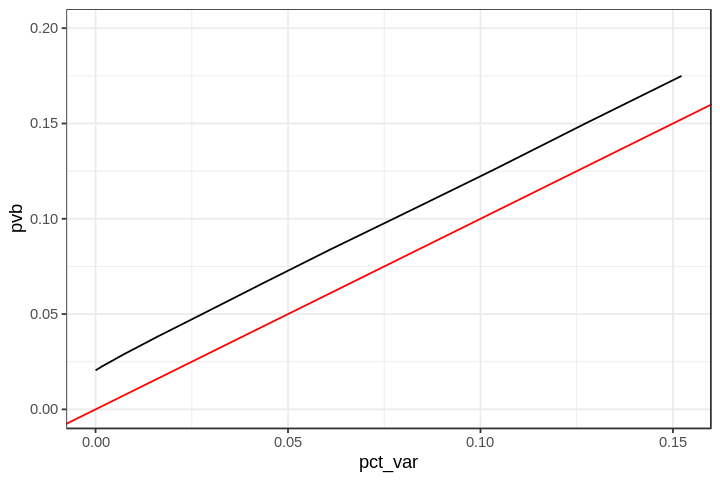

In [927]:
ax

In [928]:
file <- '~/Dropbox/tmp/pct_var-pvb.pdf'
ggsave(file, ax, width = 3.5, height = 3)

## Percentage magnitude
$$
BE
    = \frac{\sum_{i,j,k,g} \delta_k}{\sum_{i,j,k,g} X'_{ijkg}}
    = \frac{n_i n_k \delta_k}{\sum_{i,j,k,g}\alpha + \delta_i + \delta_k + \delta_g + \epsilon M_{ij}}
    = \frac{n_i n_k \delta_k}
    {n_i n_j \alpha + n_i n_j \epsilon M_{ij} + n_i \sum_g n_g \delta_g + n_j \sum_i \delta_i}
$$

where $X'$ is $X - \delta_k$.

$$ \mathbb{E}(M) = 0.5 $$

In [932]:
nbatch <- 2
ncond <- 2
npercond <- 20
n <- nbatch * ncond * npercond

ngenes <- 8000
basemean <- 5000
basedisp <- 2000
ggstep <- 100
bdispstep <- 0
swvar <- 2000

batch_delta <- 1000
class_delta <- 10000

In [933]:
calc_pct_expression <- function(
  delta_k, delta_g, delta_i, 
  n_i, n_j, alpha, epsilon,
  ret.obj = F
) {
  if (length(delta_i) != n_i)
    stop(sprintf('delta_i has to be of length %d', n_i))
  
  n_k <- n / 2 
  n_g <- n / 2
  total_batch <- n_i * n_k * delta_k
  total_x1 <- n_i * n_j * alpha + n_i * n_j * epsilon * 0.5 +
    n_i * n_g * delta_g + n_j * sum(delta_i)
  
  if (ret.obj)
    return(c(total_batch = total_batch, total_x = total_x1))
  
  total_batch / total_x1
}

In [937]:
delta_i <- seq(0, length.out = ngenes, by = ggstep)
pct_magnitude <- sapply(
  batch_deltas,
  calc_pct_expression,
  class_delta, delta_i,
  ngenes, n, basemean, swvar
)
names(pct_magnitude) <- batch_deltas

In [943]:
metrics3b <-  data.frame(pct_magnitude) %>%
  rownames_to_column(var = 'batch_delta') %>%
  merge(metrics_short, by = 'batch_delta') %>%
  mutate_all(function(x) as.numeric(as.character(x)))

In [965]:
ax <- ggplot(metrics3b) +
  geom_line(aes(x = pct_magnitude, y = gpca.delta)) + 
  geom_abline(slope = 1, intercept = 0, col = 'red') +
  ylim(0, 1)

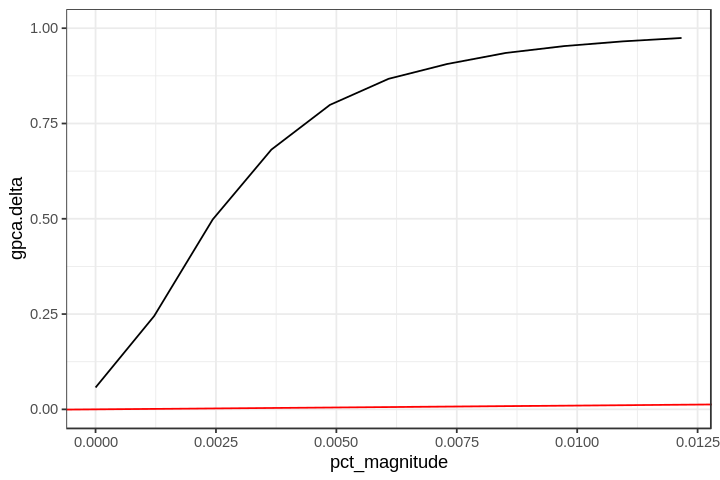

In [966]:
ax

In [967]:
file <- '~/Dropbox/tmp/pct_magnitude-gpca.pdf'
ggsave(file, ax, width = 3.5, height = 3)

In [507]:
# theoretical v.s. empirical expected sum
totals <- calc_pct_expression(
  0, class_delta, delta_i,
  ngenes, n, basemean, swvar, ret.obj = T
)

X_0 <- list_data[['0']]
empirical_sum <- sum(rowSums(X_0))
theoretical_sum <- totals['total_x']
(empirical_sum - theoretical_sum) / empirical_sum